In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime
import pandas_ta as pdt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso

### Reading Data

In [2]:
indexData_df = pd.read_csv('Dataset/indexData.csv')
indexData_p_df = pd.read_csv('Dataset/indexProcessed.csv')
info_df = pd.read_csv('Dataset/indexInfo.csv')

indexData_df = indexData_df.set_index('Date')
indexData_p_df = indexData_p_df.set_index('Date')

In [3]:
# List of indices
info_df

,Region,Exchange,Index,Currency
0,United States,New York Stock Exchange,NYA,USD
1,United States,NASDAQ,IXIC,USD
2,Hong Kong,Hong Kong Stock Exchange,HSI,HKD
3,China,Shanghai Stock Exchange,000001.SS,CNY
4,Japan,Tokyo Stock Exchange,N225,JPY
5,Europe,Euronext,N100,EUR
6,China,Shenzhen Stock Exchange,399001.SZ,CNY
7,Canada,Toronto Stock Exchange,GSPTSE,CAD
8,India,National Stock Exchange of India,NSEI,INR
9,Germany,Frankfurt Stock Exchange,GDAXI,EUR


In [4]:
# High-level view of the Dataset
indexData_df

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0
...,...,...,...,...,...,...,...
2021-05-27,N100,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
2021-05-28,N100,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
2021-05-31,N100,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0


### Feature Engineering

In [5]:
def process_index_data(df, index):
    clean_df = df[ df['Index'] == index]
    clean_df.drop('Index', inplace = True, axis=1)
    clean_df.drop('Open', inplace = True, axis=1)
    clean_df.drop('High', inplace = True, axis=1)
    clean_df.drop('Low', inplace = True, axis=1)
    clean_df.drop('Close', inplace = True, axis=1)
    
    return clean_df

In [6]:
def add_indicators(df):
    df.ta.sma(close='Adj Close', length=7, append=True)
    df.ta.sma(close='Adj Close', length=14, append=True)
    df.ta.bbands(close='Adj Close', length=7, std=1, append=True)
    df.ta.bbands(close='Adj Close', length=14, std=2, append=True)

In [7]:
def LOCF_Volume(df):
    df.loc[df['Volume'] == 0, 'Volume'] = np.nan
    df['Volume'] = df['Volume'].ffill()
    
    return df

In [8]:
def plot_SMA(df, index, start, end):
    df = df[start:end]
    plt.figure(figsize = (12,8))
    df['Adj Close'].plot(label = 'Close', linewidth = 3)
    df['SMA_7'].plot(label = 'SMA_7')
    df['SMA_14'].plot(label = 'SMA_14')
    plt.ylabel('Close')
    plt.title(index)
    plt.legend()

In [9]:
def plot_BBANDS(df, index, start, end):
    df = df[start:end]
    plt.figure(figsize = (12,8))
    df['Adj Close'].plot(label = 'Close', linewidth = 4)
    df['BBU_7_1.0'].plot(label = 'BBU_7_1.0', color = 'red')
    df['BBL_7_1.0'].plot(label = 'BBL_7_1.0', color = 'red')
    plt.fill_between(df.index, df['BBL_7_1.0'], df['BBU_7_1.0'], alpha = 0.1, color = 'red')
    df['BBU_14_2.0'].plot(label = 'BBU_14_2.0', color = 'green')
    df['BBL_14_2.0'].plot(label = 'BBL_14_2.0', color = 'green')
    plt.fill_between(df.index, df['BBL_14_2.0'], df['BBU_14_2.0'], alpha = 0.1, color = 'green')
    plt.ylabel('Close')
    plt.title(index)
    plt.legend()

In [21]:
def plot_y_vs_y_pred(X_test_index, y_test, y_pred, index):
    plt.plot(X_test_index, y_test, label = 'Acutal Price')
    plt.plot(X_test_index, y_pred, color= 'red', label = 'Predicted Price')
    plt.title(index)
    plt.legend()
    plt.show()

In [10]:
def gen_feature_and_target(df):
    X = df.loc[:,'Volume': 'BBP_14_2.0']
    y = df.loc[:,'NextClose']
    
    return X, y

### Models

### Linear Regression

In [16]:
def perform_linear_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print("Coefficient of Determination:", r2_score(y_test, y_pred))
    
    return y_pred

### LASSO Regression

In [106]:
def perform_LASSO_regression(X_train, X_test, y_train, y_test):
    model_Lasso = Lasso(alpha=20)
    model_Lasso.fit(X_train, y_train)
    yhat = model_Lasso.predict(X_test)
    
    print("Mean Absolute Error:", mean_absolute_error(y_test, yhat))
    print("Coefficient of Determination:", r2_score(y_test, yhat))
    
    return yhat

### NSEI

/Users/garimendra/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


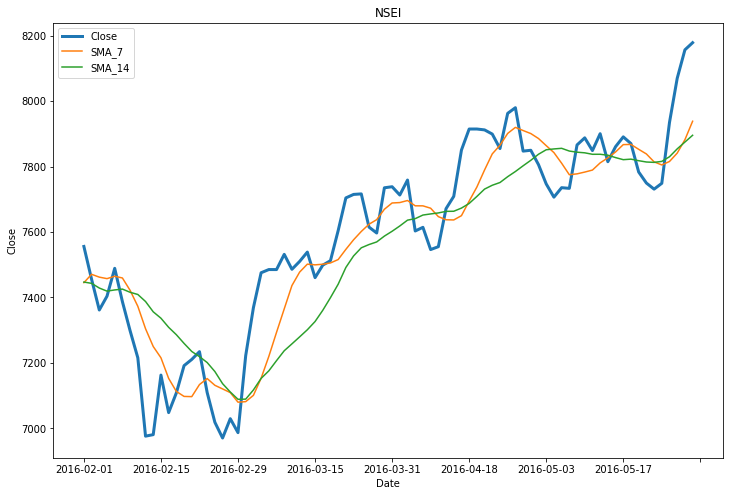

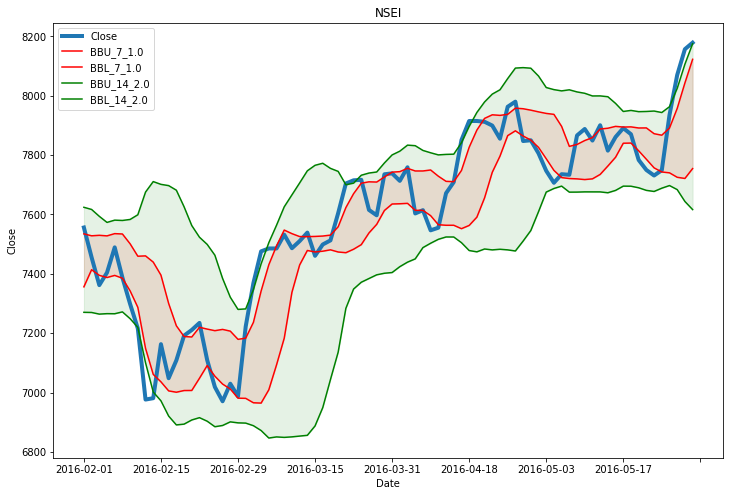

In [103]:
NSEI_df = process_index_data(indexData_df, 'NSEI')
NSEI_df = NSEI_df['2014-01-01':]
NSEI_df = LOCF_Volume(NSEI_df)

add_indicators(NSEI_df)

plot_SMA(NSEI_df, 'NSEI', '2016-02-01', '2016-05-30')
plot_BBANDS(NSEI_df, 'NSEI', '2016-02-01', '2016-05-30')

NSEI_df['NextClose'] = NSEI_df['Adj Close'].shift(-1)
NSEI_df.drop('Adj Close', inplace = True, axis=1)
NSEI_df = NSEI_df.dropna()

Mean Absolute Error: 151.11750906886803
Coefficient of Determination: 0.5006110895468308


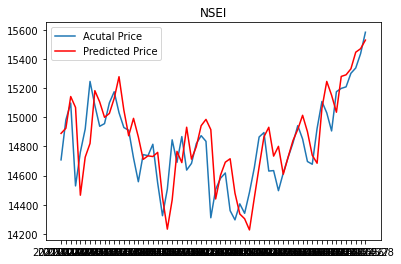

In [104]:
NSEI_df = NSEI_df['2020-01-01':'2021-10-31']
X, y = gen_feature_and_target(NSEI_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
y_pred = perform_linear_regression(X_train, X_test, y_train, y_test)

plot_y_vs_y_pred(X_test.index, y_test, y_pred, 'NSEI')

Mean Absolute Error: 143.35907482045505
Coefficient of Determination: 0.5557329601320716


/Users/garimendra/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8390770.669078398, tolerance: 71539.942307106
  model = cd_fast.enet_coordinate_descent(


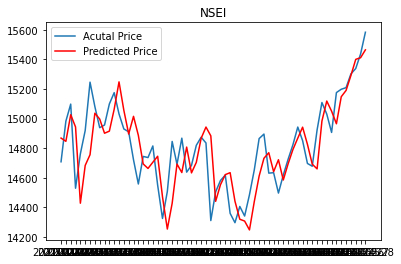

In [105]:
y_pred = perform_LASSO_regression(X_train, X_test, y_train, y_test)
plot_y_vs_y_pred(X_test.index, y_test, y_pred, 'NSEI')

### IXIC (NASDAQ)

/Users/garimendra/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


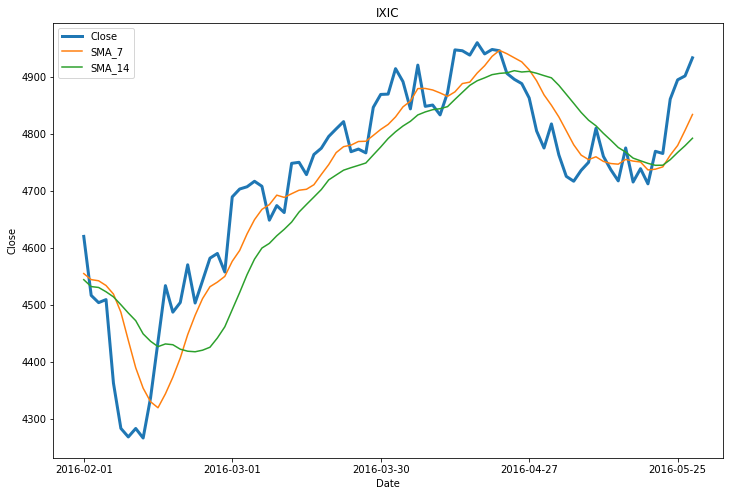

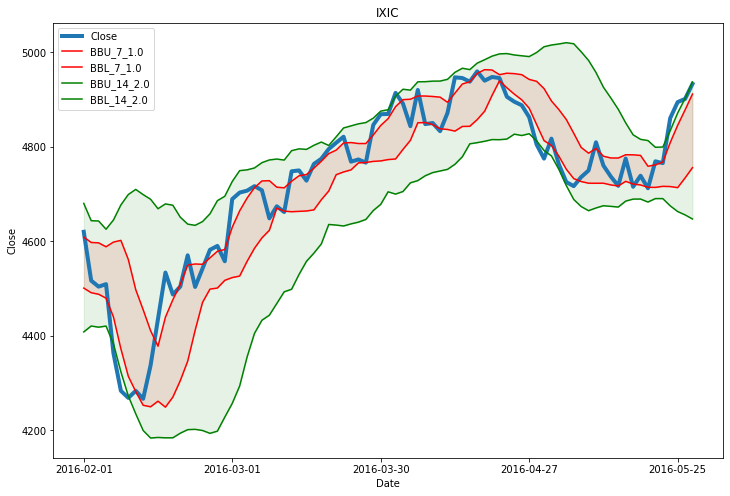

In [107]:
IXIC_df = process_index_data(indexData_df, 'IXIC')
IXIC_df = IXIC_df['2014-01-01':]
IXIC_df = LOCF_Volume(IXIC_df)

add_indicators(IXIC_df)

plot_SMA(IXIC_df, 'IXIC', '2016-02-01', '2016-05-30')
plot_BBANDS(IXIC_df, 'IXIC', '2016-02-01', '2016-05-30')

IXIC_df['NextClose'] = IXIC_df['Adj Close'].shift(-1)
IXIC_df.drop('Adj Close', inplace = True, axis=1)
IXIC_df = IXIC_df.dropna()

Mean Absolute Error: 166.0495285758559
Coefficient of Determination: 0.677221523193239


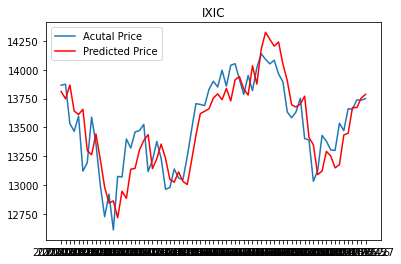

In [108]:
IXIC_df = IXIC_df['2020-01-01':'2021-10-31']
X, y = gen_feature_and_target(IXIC_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
y_pred = perform_linear_regression(X_train, X_test, y_train, y_test)

plot_y_vs_y_pred(X_test.index, y_test, y_pred, 'IXIC')

Mean Absolute Error: 176.97813774845258
Coefficient of Determination: 0.6433669860801775


/Users/garimendra/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7619132.160417211, tolerance: 83982.36919719099
  model = cd_fast.enet_coordinate_descent(


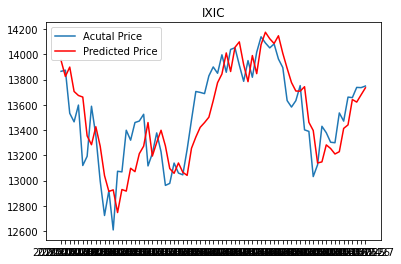

In [109]:
y_pred = perform_LASSO_regression(X_train, X_test, y_train, y_test)
plot_y_vs_y_pred(X_test.index, y_test, y_pred, 'IXIC')